# Exploratory data analysis:

For this problem, we have a dataset of over 500,000 observations. We shall use 70% of this for the training, and 30% for testing. The goal here is to use XGBoost and make a basic model first and then tune the parameters to lower our prediction error.

Before we begin, we must look for NAs and try to understand the nature of the data we have. For this we summarize the data. 

In [1]:
#Importing xgboost
library(xgboost)

#Setting the path to the directory for data
path = "/home/ankit19/Desktop/Jupyter_Notebooks/Black Friday/data"
setwd(path)

#reading training and testing data
purchaseData = read.csv("./train.csv", stringsAsFactors = F)

Now lets try and understand the type of data, and their nature that each column has for this data

In [2]:
summary(purchaseData)

    User_ID         Product_ID           Gender              Age           
 Min.   :1000001   Length:550068      Length:550068      Length:550068     
 1st Qu.:1001516   Class :character   Class :character   Class :character  
 Median :1003077   Mode  :character   Mode  :character   Mode  :character  
 Mean   :1003029                                                           
 3rd Qu.:1004478                                                           
 Max.   :1006040                                                           
                                                                           
   Occupation     City_Category      Stay_In_Current_City_Years
 Min.   : 0.000   Length:550068      Length:550068             
 1st Qu.: 2.000   Class :character   Class :character          
 Median : 7.000   Mode  :character   Mode  :character          
 Mean   : 8.077                                                
 3rd Qu.:14.000                                                
 Max.   

We can see that besides the "Product_Category_2" and "Product_Category_3" we do not have any other columns with missing values. We also notice that the columns "Age" and "Stay_In_Current_City_Years" are character types instead of numeric type so before we use XGBoost we will have to address those too. 

# Data pre-processing

We shall first address the issue of missing values from the data. Here we'll use the basic approach of replacing NA with median value of the column.  

In [3]:
#Replace every NA observed in Product_Category_2 of training data with median
purchaseData$Product_Category_2[is.na(purchaseData$Product_Category_2)] = median(purchaseData$Product_Category_2, na.rm=T)

#Replace every NA observed in Product_Category_3 of training data with median
purchaseData$Product_Category_3[is.na(purchaseData$Product_Category_3)] = median(purchaseData$Product_Category_3, na.rm=T)

Now that we have removed NAs let's shuffle the data to get a more randomized set of observations when we split it.

In [4]:
#set a random seed and shuffle
set.seed(999)
purchaseData = purchaseData[sample(1:nrow(purchaseData)), ]

#Print first 6 rows of training data
head(purchaseData)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
214016,1003056,P00034442,M,26-35,18,C,1,1,1,14,16,15345
320723,1001396,P00281542,F,26-35,12,A,4+,1,5,9,14,7092
52073,1001942,P00153742,M,36-45,5,B,1,1,8,9,14,10005
469003,1000235,P0094542,M,26-35,0,B,0,0,2,4,9,13074
432762,1000647,P00213342,M,36-45,12,B,1,1,5,9,14,7091
65646,1004048,P00220242,F,36-45,1,B,1,0,3,12,14,13251


We now have a shuffled dataset. From our summary analysis we know that the columns "Age" and "Stay_In_Current_City_Years" is of character type. But let's see if they have any levels of factors defined.

In [5]:
#Find the different age groups defined in the Age column
Age_Groups = factor(purchaseData$Age)
levels(Age_Groups)

[1] "0-17"  "18-25" "26-35" "36-45" "46-50" "51-55" "55+"

We see that 7 different age groups are defined in the column. But we can't have our data in this categorical format if we want to use XGBoost. Hence we'll use one-hot coding to create a sparse matrix for this categorical data.

In [6]:
#One-hot matrix for the column "Age"
Age_Groups_Matrix = model.matrix(~Age-1, purchaseData)

Now let's apply the same procedures of finding the factors and conversion procedure on Stay_In_Current_City_Years column as well.

In [7]:
#Find the different values in the Stay_In_Current_City_Years column
Years_Of_Stay = factor(purchaseData$Stay_In_Current_City_Years)
levels(Years_Of_Stay)

[1] "0"  "1"  "2"  "3"  "4+"

In [8]:
#One-hot matrix for the column "Stay_In_Current_City_Years"
Years_Of_Stay_Matrix = model.matrix(~Stay_In_Current_City_Years-1, purchaseData)

Now the only columns, besides "Product_ID", that are non-numeric are "Gender" and "City_Category" so we should encode them as well for XGBoost. We will not convert values of "Product_ID" because we won't be using this column for training our model.

In [9]:
#One-hot matrix for the column "City_Category"
City_Category_Matrix = model.matrix(~City_Category-1, purchaseData)

#One-hot matrix for the column "Gender"
Gender_Matrix = model.matrix(~Gender-1, purchaseData)

Now that we have made all necessary changes we must do the following:
    1. Retain only numeric columns
    2. Store the values of the target variable separately
    3. Drop the target variable from the dataframe
    4. Convert the final, all numeric dataframe into a matrix

In [10]:
#Taking the subset of only numeric columns and 
# dropping the target variable "Purchase"
purchaseData_Onlynumeric = subset(purchaseData, select = -c(Product_ID, Gender, Age, City_Category, Stay_In_Current_City_Years, Purchase))

#Storing the target variable
purchaseValues =  purchaseData$Purchase

#Combining all the sparse matrices with the all numeric dataframe
purchaseData_Matrix = cbind(purchaseData_Onlynumeric, Gender_Matrix, Age_Groups_Matrix, City_Category_Matrix, Years_Of_Stay_Matrix)

Now that we have our complete matrix ready, let's split it into training and testing sets. The training set will have 80% of observations whereas the testing set will have 20%.

In [11]:
n_Observations = round(length(purchaseValues) * 0.7)

#Training data and the corresponding target variables
purchaseTrain = purchaseData_Matrix[1:n_Observations, ]
purchaseValues_Train = purchaseValues[1:n_Observations]

#Testing data and the corresponding target variables
purchaseTest = purchaseData_Matrix[-(1:n_Observations), ]
purchaseValues_Test =  purchaseValues[-(1:n_Observations)]

Further we convert the training and testing sets to dmatrix. This will quicken our training process.

In [12]:
#First convert the dataframe to a matrix
purchaseTrain = as.matrix(purchaseTrain)
purchaseTest = as.matrix(purchaseTest)

#Then convert the matrix to a dmatrix
d_train = xgb.DMatrix(data = purchaseTrain, label = purchaseValues_Train)
d_test = xgb.DMatrix(data = purchaseTest, label = purchaseValues_Test)

# Training the model
Now that we have both the training and testing sets in the desired format, we shall proceed with training the initial model and measure the error to tune the model further. 

In [13]:
model = xgboost(data = d_train, nround = 500, objective = "reg:linear")

[1]	train-rmse:7684.694336 
[2]	train-rmse:5787.736328 
[3]	train-rmse:4578.776367 
[4]	train-rmse:3847.539795 
[5]	train-rmse:3430.173096 
[6]	train-rmse:3206.232178 
[7]	train-rmse:3085.054688 
[8]	train-rmse:3021.175781 
[9]	train-rmse:2987.185547 
[10]	train-rmse:2967.730469 
[11]	train-rmse:2955.302246 
[12]	train-rmse:2946.292969 
[13]	train-rmse:2940.396729 
[14]	train-rmse:2935.267578 
[15]	train-rmse:2930.721924 
[16]	train-rmse:2925.091797 
[17]	train-rmse:2922.216797 
[18]	train-rmse:2917.476807 
[19]	train-rmse:2913.333252 
[20]	train-rmse:2911.729980 
[21]	train-rmse:2908.882568 
[22]	train-rmse:2903.523438 
[23]	train-rmse:2900.829102 
[24]	train-rmse:2898.748779 
[25]	train-rmse:2894.042480 
[26]	train-rmse:2889.906006 
[27]	train-rmse:2886.266357 
[28]	train-rmse:2885.307617 
[29]	train-rmse:2883.059570 
[30]	train-rmse:2880.306885 
[31]	train-rmse:2877.258301 
[32]	train-rmse:2876.264160 
[33]	train-rmse:2874.545898 
[34]	train-rmse:2870.686768 
[35]	train-rmse:2869.45

So from the model we just trained, we see that the Root Mean Square Error (RMSE) decreases rapidly, coming as low as 2591 from the initial RMSE value of more than 7000. Now let's see how this model performs with our test data. We'll take the average of the error as observed in the predictions.

In [51]:
#Calculate the purchase price for testing data
pred_purchase = predict(model, d_test)

#Calculate the RMSE observed
purchase_err = pred_purchase - purchaseValues_Test
rmse = sqrt(mean(purchase_err^2))
rmse

[1] 2758.965

So we can see that there's a significant difference in the RMSE values calculated for the training and the testing set. The model, although performing fairly well, is overfitting a little bit. We can reduce this error by further tuning the model.

# Tuning the model

To reduce overfitting we will tune the model in the following aspects:
    1. Control complexity: this means including max_depth, min_child_weight, and gamma
    2. Introduce randomness: this means including colsample_bytree, subsample, and eta
    
So now we must tune and create different models with varied parameter values and then finalize the model that produces the least RMSE.

In [52]:
model_tuned1 = xgboost(data = d_train,
                      eta = 0.1,                     #controls the step size shrinkage, default=0.3
                      nround = 50,                   #since we are decreasing the eta, we need high nround value
                      objective = "reg:linear",
                      max_depth = 15,                #reduces the depth of the trees to reduce complexity
                      min_child_weight = 100,        #higher the value, more instances required to make a node
                      gamma = 100,                   #minimum loss reduction required to make further partition of a leaf node
                      subsample = 0.5,               #subsamples the instances in the training set by half
                      colsample_bytree = 0.5)

[1]	train-rmse:9729.503906 
[2]	train-rmse:8963.846680 
[3]	train-rmse:8313.514648 
[4]	train-rmse:7595.486328 
[5]	train-rmse:7070.075684 
[6]	train-rmse:6637.600586 
[7]	train-rmse:6271.372070 
[8]	train-rmse:5788.150879 
[9]	train-rmse:5500.750488 
[10]	train-rmse:5107.929199 
[11]	train-rmse:4899.496094 
[12]	train-rmse:4724.195801 
[13]	train-rmse:4557.495605 
[14]	train-rmse:4439.103516 
[15]	train-rmse:4329.604980 
[16]	train-rmse:4227.562988 
[17]	train-rmse:4008.449463 
[18]	train-rmse:3937.497559 
[19]	train-rmse:3881.888672 
[20]	train-rmse:3835.854248 
[21]	train-rmse:3792.937744 
[22]	train-rmse:3755.088623 
[23]	train-rmse:3604.050293 
[24]	train-rmse:3580.314453 
[25]	train-rmse:3456.925293 
[26]	train-rmse:3439.077393 
[27]	train-rmse:3425.802490 
[28]	train-rmse:3326.429199 
[29]	train-rmse:3249.381836 
[30]	train-rmse:3180.477051 
[31]	train-rmse:3166.950684 
[32]	train-rmse:3105.676758 
[33]	train-rmse:3056.200684 
[34]	train-rmse:3050.219238 
[35]	train-rmse:3004.95

In [84]:
#Calculate the purchase price for testing data
pred_purchase1 = predict(model_tuned1, d_test)

#Calculate the RMSE observed
purchase_err1 = pred_purchase1 - purchaseValues_Test
rmse1 = sqrt(mean(purchase_err1^2))
print(paste("RMSE1: ",rmse1))

#Fetching the RMSE calculated in the last iteration
eval_log = model_tuned1[4]
log = eval_log[[1]]
rmse_calc1 = log$train_rmse[log$iter==50]
print(paste("RMSE1 difference: ", rmse1-rmse_calc1))

[1] "RMSE1:  2911.17034740029"
[1] "RMSE1 difference:  42.5895364002936"


In [85]:
model_tuned2 = xgboost(data = d_train,
                      eta = 0.1,                     #controls the step size shrinkage, default=0.3
                      nround = 100,                  #since we are decreasing the eta, we need high nround value
                      objective = "reg:linear",
                      max_depth = 10,                #reduces the depth of the trees to reduce complexity
                      min_child_weight = 150,        #higher the value, more instances required to make a node
                      gamma = 100,                   #minimum loss reduction required to make further partition of a leaf node
                      subsample = 0.5,               #subsamples the instances in the training set by half
                      colsample_bytree = 0.5)

[1]	train-rmse:9578.111328 
[2]	train-rmse:8810.934570 
[3]	train-rmse:8147.248535 
[4]	train-rmse:7447.132812 
[5]	train-rmse:6938.682129 
[6]	train-rmse:6376.820312 
[7]	train-rmse:5971.988770 
[8]	train-rmse:5649.116211 
[9]	train-rmse:5245.663574 
[10]	train-rmse:4895.776367 
[11]	train-rmse:4590.961426 
[12]	train-rmse:4327.969727 
[13]	train-rmse:4163.589844 
[14]	train-rmse:3961.343994 
[15]	train-rmse:3838.519287 
[16]	train-rmse:3740.436035 
[17]	train-rmse:3603.364502 
[18]	train-rmse:3483.074463 
[19]	train-rmse:3384.973633 
[20]	train-rmse:3304.579590 
[21]	train-rmse:3265.326416 
[22]	train-rmse:3203.305420 
[23]	train-rmse:3173.202148 
[24]	train-rmse:3127.561279 
[25]	train-rmse:3088.990234 
[26]	train-rmse:3057.566406 
[27]	train-rmse:3044.606934 
[28]	train-rmse:3020.217285 
[29]	train-rmse:2999.631836 
[30]	train-rmse:2980.692627 
[31]	train-rmse:2966.509766 
[32]	train-rmse:2959.669678 
[33]	train-rmse:2945.194092 
[34]	train-rmse:2941.806641 
[35]	train-rmse:2935.82

In [86]:
#Calculate the purchase price for testing data
pred_purchase2 = predict(model_tuned2, d_test)

#Calculate the RMSE observed
purchase_err2 = pred_purchase2 - purchaseValues_Test
rmse2 = sqrt(mean(purchase_err2^2))
print(paste("RMSE2: ",rmse2))

#Fetching the RMSE calculated in the last iteration
eval_log = model_tuned2[4]
log = eval_log[[1]]
rmse_calc2 = log$train_rmse[log$iter==100]
print(paste("RMSE2 difference: ", rmse2-rmse_calc2))

[1] "RMSE2:  2839.06907897793"
[1] "RMSE2 difference:  21.6010609779319"


In [87]:
model_tuned3 = xgboost(data = d_train,
                      eta = 0.1,                     #controls the step size shrinkage, default=0.3
                      nround = 500,                  #since we are decreasing the eta, we need high nround value
                      objective = "reg:linear",
                      max_depth = 10,                #reduces the depth of the trees to reduce complexity
                      min_child_weight = 200,        #higher the value, more instances required to make a node
                      gamma = 150,                   #minimum loss reduction required to make further partition of a leaf node
                      subsample = 0.5,               #subsamples the instances in the training set by half
                      colsample_bytree = 0.5)

[1]	train-rmse:9579.466797 
[2]	train-rmse:8811.900391 
[3]	train-rmse:8160.341797 
[4]	train-rmse:7566.859375 
[5]	train-rmse:6931.979492 
[6]	train-rmse:6370.618164 
[7]	train-rmse:5991.699707 
[8]	train-rmse:5545.004883 
[9]	train-rmse:5153.651367 
[10]	train-rmse:4899.008789 
[11]	train-rmse:4594.241699 
[12]	train-rmse:4329.546387 
[13]	train-rmse:4104.196777 
[14]	train-rmse:3911.833740 
[15]	train-rmse:3746.194580 
[16]	train-rmse:3607.281006 
[17]	train-rmse:3488.724365 
[18]	train-rmse:3419.525635 
[19]	train-rmse:3360.657471 
[20]	train-rmse:3313.066406 
[21]	train-rmse:3243.010742 
[22]	train-rmse:3183.727051 
[23]	train-rmse:3134.784668 
[24]	train-rmse:3092.535156 
[25]	train-rmse:3059.231934 
[26]	train-rmse:3032.929199 
[27]	train-rmse:3019.089600 
[28]	train-rmse:3007.075684 
[29]	train-rmse:2997.207520 
[30]	train-rmse:2989.613281 
[31]	train-rmse:2984.018799 
[32]	train-rmse:2968.790283 
[33]	train-rmse:2954.701172 
[34]	train-rmse:2944.305664 
[35]	train-rmse:2940.84

In [88]:
#Calculate the purchase price for testing data
pred_purchase3 = predict(model_tuned3, d_test)

#Calculate the RMSE observed
purchase_err3 = pred_purchase3 - purchaseValues_Test
rmse3 = sqrt(mean(purchase_err3^2))
print(paste("RMSE3: ",rmse3))

#Fetching the RMSE calculated in the last iteration
eval_log = model_tuned3[4]
log = eval_log[[1]]
rmse_calc3 = log$train_rmse[log$iter==500]
print(paste("RMSE3 difference: ", rmse3-rmse_calc3))

[1] "RMSE3:  2783.1487690343"
[1] "RMSE3 difference:  69.0865130343022"


So we see that the second model performed the best amongst the three models with the least difference in the RMSE as observed on training and testing data. Hence we'll proceed with that model. It should be noted that at this point we can try to lower the difference in the RMSE by using different parameter values.

# Feature importance

Now that we have trained our model, we can observe and evaluate it. One important insight that can be drawn from the use of XGBoost model is that which of the variables/features play an important role in prediction. Here's how it is done:

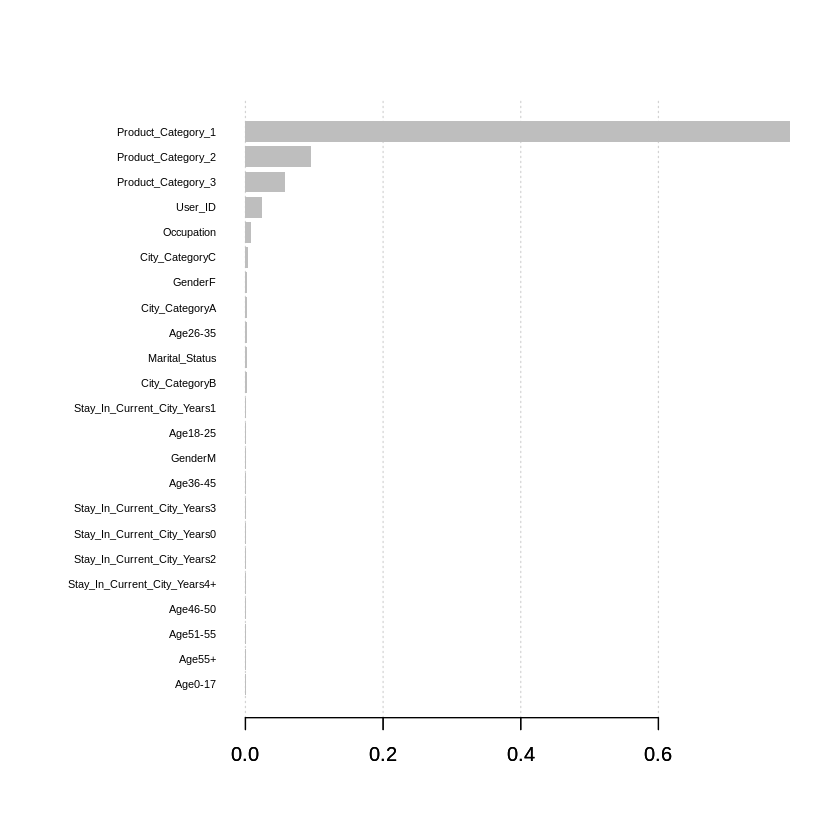

In [89]:
#Matrix containing data on the importance of each variable
importance_matrix <- xgb.importance(names(purchaseData_Matrix), model = model_tuned2)

# and plot it!
xgb.plot.importance(importance_matrix)

As it can be seen from the importance_matrix plot that the variable "Product_Category_1" seems to be the most important variable, followed by the "Product_Category_2", "Product_Category_3", and "User_ID". This suggests that to improve the model's performance, we can incorporate feature engineering to emphasize on the purchasing pattern of a particular user.

Moreover, with the information on the relationship of the customer or user and the product category, that he or she purchases more often, the organization can market their products much more effeciently, with effective results.